In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME="./config_bdd.csv"
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "compile", "vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
        # categorical variable
        #if tuxdata[col].dtype == 'object':
        #    try:
        #        tuxdata[col] = tuxdata[col].astype('category')
        #    except:
        #        print('Column', ' ', col, ' cannot be converted to category.')
    else:
        non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
non_tristate_options.remove('LZO') # ('vmlinux')


#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))
# maybe we can drop options with only one unique value (no interest for machine learning)
rawtuxdata.drop(columns=ftuniques,inplace=True)

print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))

print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()
    



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11858,12250,12340,12341,12364,12369,12378,12384) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (9958, 12819)
Number of options with only one value (eg always y): (3422, 1)
Non tri-state value options (eg string or integer or hybrid values): (164, 1) 
Predictor variables: 9233


In [2]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,FONT_10x18,FONT_SUN8x16,FONT_SUN12x22,FONT_AUTOSELECT,SG_SPLIT,SG_POOL,STACKDEPOT,SBITMAP,PARMAN,PRIME_NUMBERS
0,60510,2018-06-27 04:19:12,576.864,18621240,4366800,6452344,4223069,8323536,10408528,4062026,...,n,n,n,n,n,n,n,n,n,n
1,60511,2018-06-27 04:19:24,764.404,99653960,11989456,14075000,11845475,15688144,17773136,11422982,...,n,n,n,n,n,y,y,y,n,n
2,60512,2018-06-27 04:19:25,517.192,49309232,10491344,12577448,10290099,14824912,16910464,10504495,...,n,n,n,n,n,n,y,n,n,y
3,60513,2018-06-27 04:19:40,339.020,23717136,5624784,7710160,5475266,9483216,11568040,5217081,...,n,n,n,n,y,n,y,n,n,n
4,60514,2018-06-27 04:20:01,821.146,66382096,14954960,17042296,14744538,19026384,21113168,14696697,...,y,y,y,n,n,y,y,y,n,n
5,60515,2018-06-27 04:20:01,855.771,34193272,8520144,10606032,8373198,12272080,14357416,8006031,...,n,n,n,n,n,y,y,y,n,m
6,60516,2018-06-27 04:20:24,701.625,24497136,5960656,8046032,5812171,9929680,12014504,5662301,...,n,n,n,n,n,n,y,n,y,y
7,60517,2018-06-27 04:20:36,248.743,26591480,6034384,8119760,5885494,9794512,11879336,5529507,...,n,n,n,n,n,n,y,n,n,n
8,60518,2018-06-27 04:20:36,249.222,26591480,6034384,8119760,5885492,9794512,11879336,5529524,...,n,n,n,n,n,n,y,n,n,n
9,60519,2018-06-27 04:20:44,537.290,175305384,29709776,31796040,29506827,33564112,35649824,29242095,...,n,n,n,y,y,y,y,y,y,y


<Figure size 432x288 with 0 Axes>

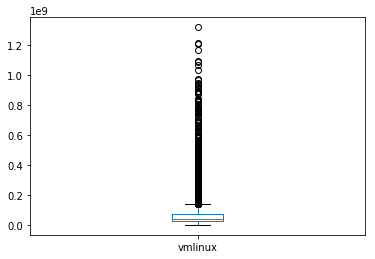

<Figure size 432x288 with 0 Axes>

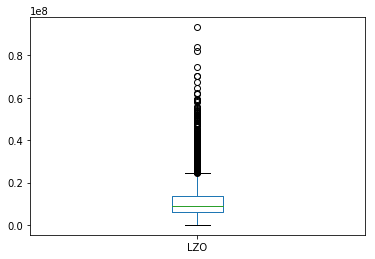

In [4]:
plt.figure()
pd.DataFrame(rawtuxdata['vmlinux']).plot.box()
plt.show()

plt.figure()
pd.DataFrame(rawtuxdata['LZO']).plot.box()
plt.show()

In [65]:
import scipy.stats
import seaborn as sns


size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]
n_size_methods = len(size_methods)

cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)





def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)

#(rawtuxdata["XZ-vmlinux"] - rawtuxdata["BZIP2-vmlinux"]).plot.box()
#corr_sizes = [[0 for x in range(n_size_methods)] for y in range(n_size_methods)]
#i = 0
#j = 0
#for size_method in size_methods:
#    csize = rawtuxdata[size_method]   
#    for osize_method in size_methods:
#        if size_method != osize_method:
#            osize = rawtuxdata[osize_method]           
#            pcorr = scipy.stats.pearsonr(csize, osize)[0]
#            corr_sizes[i][j] = pcorr
#        j = j + 1
#    i = i + 1

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-24.695,17.9851,27.1061,-7.7575,-12.685
BZIP2o,35.2606,0,59.3945,71.6043,24.7532,18.0618
LZMAo,-14.9771,-35.9622,0,7.62641,-21.4452,-25.5635
XZo,-20.7233,-40.271,-6.86268,0,-26.7163,-30.5303
LZOo,8.5288,-18.3039,28.2464,38.2103,0,-5.40089
LZ4o,14.8408,-13.5746,35.8329,46.4246,5.74986,0


In [5]:
#from category_encoders import *
from sklearn.preprocessing import *

#X = [['y', 1], ['n', 3], ['m', 2]]
#enc.fit(X)
#enc.transform(tuxdata)

#enc = OrdinalEncoder().fit(tuxdata[:10])

# transform the dataset
#enc.transform(tuxdata[:10])

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
#print(non_tristate_options)

# we save quantitative values we want (here vmlinux, TODO: generalize)
# the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 


# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['LZO']).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
tuxdata['LZO'] = vml
# tuxdata['vmlinux'].astype('int64')

# example: DEBUG_INFO is either y or n
tuxdata['DEBUG_INFO'].unique()

array([0, 1])

In [6]:
# remove entries with same configurations
print(str(len(tuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['LZO']), inplace=True)
print(str(len(tuxdata)) + " after the removal of some entries (those with same configurations)")

9958 before the removal of some entries (those with same configurations)
9928 after the removal of some entries (those with same configurations)


In [7]:
#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
n_failures = len(tuxdata[~np.isnan(tuxdata['LZO'])])
print(str(n_failures) + " failures out of " + str(len(tuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
tuxdata = tuxdata[~np.isnan(tuxdata['LZO'])]
print(str(len(tuxdata)) + " after the removal of configurations that do NOT compile")

#tuxdata["vmlinux"]
#tuxdata.where(tuxdata["vmlinux"] == np.NaN)

#tuxdata[tuxdata["vmlinux"] != -1]
#tuxdata


9928 failures out of 9928
9928 after the removal of configurations that do NOT compile


In [8]:
# tuxdata.where(not np.isnan(tuxdata["vmlinux"]))
#tuxdata["vmlinux"][16] == np.isnan
#vml == -1 
#tuxdata["vmlinux"] == -1
#tuxdata['vmlinux'].dtypes
#vml.dtypes
#tuxdata['vmlinux'].dtypes #.astype('int64')


In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline



TESTING_SIZE=0.1 

# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)



X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=['LZO']), tuxdata['LZO'], test_size=TESTING_SIZE, random_state=0)  

# train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

#clf = RandomForestRegressor(n_estimators=100) 
clf = GradientBoostingRegressor(n_estimators=100)  # 
#clf = Pipeline([
#  ('feature_selection', SelectFromModel(LassoCV())),
#  ('regression', GradientBoostingRegressor(n_estimators=100))
# ])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]    

TOP_FT_IMPORTANCE=20
print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
for f in range(TOP_FT_IMPORTANCE): # len(indices)
    print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances for size of vmlinux")
#plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
#plt.xticks(range(tuxdata.shape[1]), indices)
#plt.xlim([-1, tuxdata.shape[1]])
#plt.show()
mae = mean_absolute_error (y_test, y_pred)
mse = mean_squared_error (y_test, y_pred) 
r2 = r2_score (y_test, y_pred) 
print("Prediction score (MAE): %.2f" % (mae))
print("Prediction score (MSE): %.2f" % (mse))
print("Prediction score (R2): %.2f" % (r2))


Feature ranking: top (20)
1. feature UBSAN_SANITIZE_ALL 8832 (0.112339)
2. feature AIC79XX_BUILD_FIRMWARE 1950 (0.069754)
3. feature GCOV_PROFILE_ALL 185 (0.057378)
4. feature AIC7XXX_BUILD_FIRMWARE 1946 (0.056785)
5. feature WANXL_BUILD_FIRMWARE 3008 (0.042819)
6. feature KASAN_OUTLINE 8670 (0.039640)
7. feature KASAN 8669 (0.030087)
8. feature DRM_VBOXVIDEO 7452 (0.023984)
9. feature STRICT_MODULE_RWX 182 (0.021050)
10. feature UBSAN_ALIGNMENT 8833 (0.020474)
11. feature KCOV_INSTRUMENT_ALL 8673 (0.018583)
12. feature BLK_MQ_PCI 244 (0.012134)
13. feature MODULES 189 (0.012043)
14. feature GENERIC_ALLOCATOR 9179 (0.011051)
15. feature X86_NEED_RELOCS 424 (0.010405)
16. feature XFS_FS 8317 (0.009877)
17. feature SECURITY_INFINIBAND 8872 (0.008806)
18. feature DRM_AMDGPU 5401 (0.008688)
19. feature SCSI_ISCSI_ATTRS 1925 (0.008610)
20. feature USB 6356 (0.008513)
Prediction score (MAE): 1676619.05
Prediction score (MSE): 11542967544622.18
Prediction score (R2): 0.80


In [10]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

True

In [11]:
# tuxdata.where(tuxdata["vmlinux"] != -1).sort_values(by='vmlinux')[:5] # & 